# Create Dataset from Google Images

In [1]:
from fastai.vision import *

Files already downloaded in `data` folder

In [7]:
%ls ../../../data/bicycles

city/  folding/  mountain/  road/


In [9]:
path = Path('../../../data/bicycles')

In [10]:
path.ls()

[PosixPath('../../../data/bicycles/mountain'),
 PosixPath('../../../data/bicycles/road'),
 PosixPath('../../../data/bicycles/folding'),
 PosixPath('../../../data/bicycles/city')]

Let's verify the images, with auto delete option for invalid files

In [11]:
classes = ['mountain', 'road', 'folding', 'city']

In [12]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

mountain


road


folding


city


We can then create `ImageDataBunch` from the verified data

In [14]:
data = ImageDataBunch.from_folder(
    path, 
    train='.', 
    valid_pct=0.2, 
    ds_tfms=get_transforms(), 
    size=224, 
    num_workers=4
).normalize(imagenet_stats)

Take a look at some of the pics

In [15]:
data.classes

['city', 'folding', 'mountain', 'road']

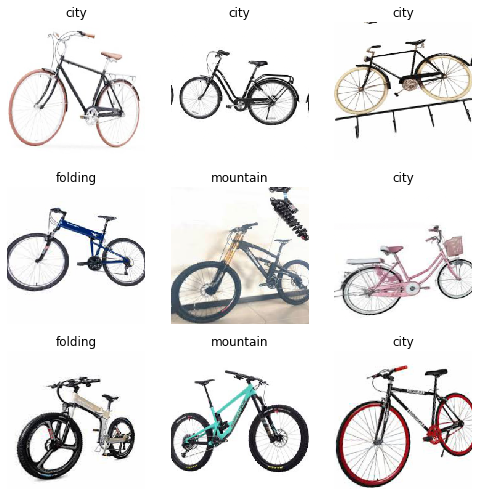

In [16]:
data.show_batch(rows=3, figsize=(7,7))

## Train model

In [22]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [23]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,error_rate,time
0,2.139796,1.162740,0.495413,00:02
1,1.509570,0.688912,0.183486,00:02
2,1.195266,0.655703,0.174312,00:02
3,0.965608,0.566134,0.155963,00:02
4,0.808266,0.551170,0.155963,00:02


In [24]:
learn.save('stage-1')

In [25]:
learn.unfreeze()

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


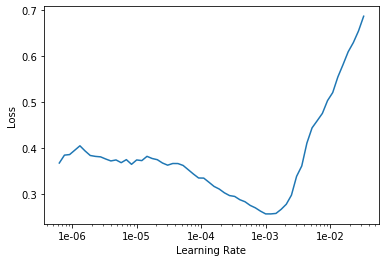

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 5e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.366440,0.489510,0.119266,00:03
1,0.343690,0.417926,0.100917,00:03


In [30]:
learn.fit_one_cycle(2, max_lr=slice(1e-5, 3e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.212743,0.409693,0.091743,00:03
1,0.167902,0.407274,0.091743,00:03


In [31]:
learn.save('stage-2')

## Interpretation

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

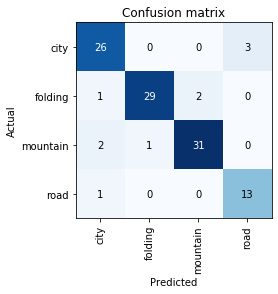

In [33]:
interp.plot_confusion_matrix()

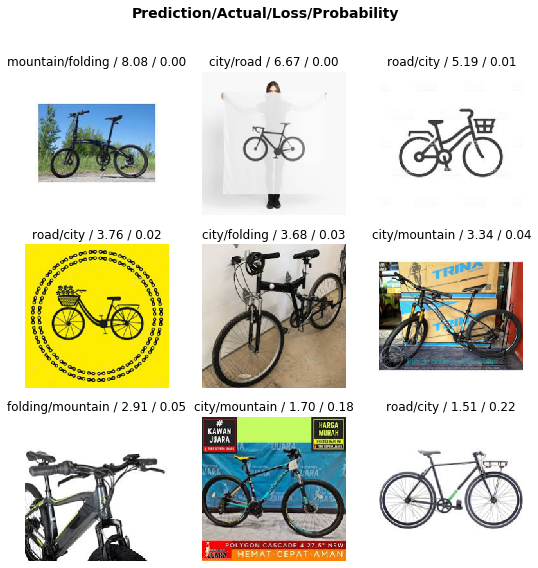

In [34]:
interp.plot_top_losses(9, figsize=(9,9))

Good enough!

## Putting the model in production

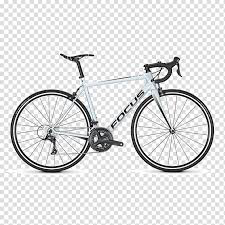

In [36]:
img = open_image(path/'road'/'00000021.jpg')
img

In [37]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category road

Nice, that's how we can feed the model with image and it will predict the category. However, it still runs on GPU. In production, having GPU instance is just unreasonably expensive for our purpose.

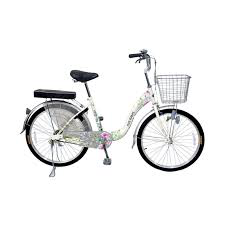

In [47]:
img = open_image(path/'city'/'00000004.jpg')
img

Now we try to use CPU only

To put the model in production, you need to export your model, to then be loaded.

In [43]:
learn.export()

In [44]:
defaults.device = torch.device('cpu')

In [45]:
learn = load_learner(path)

In [48]:
pred_class, pred_idx, outputs = learn.predict(img)
pred_class

Category city

Nice!